# Anomaly  Detection using  Convolutional VAE

[Go to Google Colab](https://colab.research.google.com/github/seungjin-yang/anomaly-detection/blob/master/convolutional-vae.ipynb)

In [0]:
%matplotlib inline
from urllib.error import HTTPError

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.datasets import EMNIST
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.utils import save_image

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.2.0
0.4.0


### Dataset

In [0]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [0]:
datasets_root = '/tmp/torchvision/'

In [7]:
mnist_train, mnist_valid = torch.utils.data.random_split(
    dataset=MNIST(datasets_root, train=True, download=True, transform=transform),
    lengths=(50000, 10000))

mnist_test = MNIST(datasets_root, train=False, transform=transform)

0it [00:00, ?it/s]

9920512it [00:01, 9685959.72it/s]                            


Extracting /tmp/torchvision/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/torchvision/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135584.30it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /tmp/torchvision/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/torchvision/MNIST/raw


1654784it [00:00, 2400687.05it/s]                           
0it [00:00, ?it/s]

Extracting /tmp/torchvision/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/torchvision/MNIST/raw


8192it [00:00, 49538.48it/s]            

Extracting /tmp/torchvision/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/torchvision/MNIST/raw
Processing...
Done!


In [10]:
print(f'MNIST Training: {len(mnist_train)}')
print(f'MNIST Validation: {len(mnist_valid)}')
print(f'MNIST Test: {len(mnist_test)}')

MNIST Training: 50000
MNIST Validation: 10000
MNIST Test: 10000


In [0]:
def show_mnist(dataset, start=0, end=64, is_flat=True):
    if isinstance(dataset, torch.utils.data.Dataset):
        images = [dataset[idx][0] for idx in range(start, end)]

        if is_flat:
            images = [each.view(1, 28, 28) for each in images]
    elif isinstance(dataset, torch.Tensor):
        images =  dataset
        if is_flat:
            images = [each.view(1, 28, 28) for each in images]
        
        
    images = make_grid(images, padding=5)
    images = images.numpy()
    images = np.transpose(images, (1, 2, 0))
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(images, interpolation='nearest')
    ax.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)

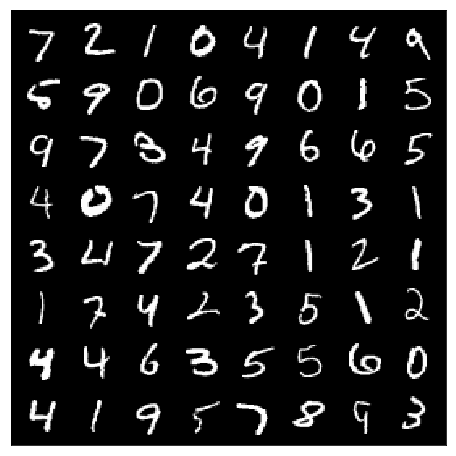

In [12]:
show_mnist(mnist_test, end=64)

### DataLoader

In [0]:
batch_size = 128
test_batch_size = 512

In [0]:
train_loader = DataLoader(mnist_train, batch_size=batch_size)
valid_loader = DataLoader(mnist_valid, batch_size=test_batch_size)
test_loader = DataLoader(mnist_test, batch_size=test_batch_size)

# Model

### Encoder
$$
\Large q_{\phi}(\mathbf{z}|\mathbf{x})
$$

In [0]:
class Encoder(nn.Module):
    '''
    (Probabilistic) Encoder
    Inference Model
    '''
    def __init__(self, dim_latent=20):
        super(Encoder, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2)
        self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.linear = nn.Linear(in_features=64, out_features=2*dim_latent)
        
    def reparameterize(self, mean, log_variance):
        # standad deviation
        std = torch.exp(0.5 * log_variance)
        eps = torch.randn_like(std)
        return mean + eps * std
    
    def forward(self, x):
        h = self.conv_1(x)
        h = F.relu(h)
        h = self.conv_2(h)
        h = F.relu(h)
        
        h = h.mean(dim=(1, 2, 3))
        h = self.linear(h)
        mean = h[:, self.dim_latent]
        log_variance = h[:, self.dim_latent: ]
        z = self.reparameterize(mean, log_variance)
        return z, mean, log_variance

### Decoder
$$
\Large p_{\theta}(\mathbf{x}, \mathbf{z})
$$

In [0]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.linear = nn.Linear(in_features=dim_latent, out_features=32*7*7)
        self.conv_1 = nn.ConvTranspose2d(
            in_features=32, kernel_size=32)
    
    def forward(self, z):
        h3 = F.relu(self.fc3(z))
        x_recon = torch.sigmoid(self.fc4(h3))
        return x_recon

In [0]:
    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )


### VAE

In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z, mean, log_variance = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, mean, log_variance

### Loss function

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
# see Appendix B from VAE paper:
# Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
# https://arxiv.org/abs/1312.6114
# 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
def loss_function(x_recon, x, mean, log_variance):
    reco_error = F.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())
    return reco_error + kl_divergence

In [0]:
def reconstruction_error(x_recon, x, reduction='sum'):
    return F.binary_cross_entropy(x_recon, x, reduction=reduction)

In [0]:
def kl_divergence(mean, log_variance):
    return -0.5 * torch.sum(1 + log_variance - mean.pow(2) - log_variance.exp())

In [0]:
def train(model, data_loader, optimizer, device):
    model.train()
       
    #log_interval = int(len(data_loader) / 10)
    
    for batch_idx, (data, _) in enumerate(data_loader):
        data = data.to(device)
        
        optimizer.zero_grad()
        
        recon_batch, mean, log_variance = model(data)
        
        reco_error = reconstruction_error(recon_batch, data)
        kld = kl_divergence(mean, log_variance)
        

        loss = reco_error + kld
        
        loss.backward()
        optimizer.step()
        
        # if batch_idx % log_interval == 0:
            
        #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        #         epoch, batch_idx * len(data), len(data_loader.dataset),
        #        100. * batch_idx / len(data_loader),
        #        loss.item() / len(data)))

    #average_loss = accumulated_loss / len(data_loader.dataset)
    #return average_loss

In [0]:
def test(model, data_loader, device):
    model.eval()
    
    # accumulated loss
    accum_reco_error = 0
    accum_kld = 0
    
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(data_loader):
            data = data.to(device)
            recon_batch, mean, log_variance = model(data)
            
            reco_error = reconstruction_error(recon_batch, data)
            kld = kl_divergence(mean, log_variance)
            
            accum_reco_error += reco_error.item()
            accum_kld += kld.item()

    num_examples = len(data_loader.dataset)
    
    average_reco_error = accum_reco_error / num_examples
    average_kld = accum_kld / num_examples
    average_loss = average_reco_error + average_kld
    
    return average_loss, (average_reco_error, average_kld)

In [0]:
device = torch.device('cuda:0')
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [0]:
epochs = 100

In [0]:
for epoch in range(1, epochs + 1):
    train(model, train_loader, optimizer, device)
    
    train_loss, (train_reco_error, train_kld) = test(model, train_loader, device)
    valid_loss, (valid_reco_error, valid_kld) = test(model, valid_loader, device)
    
    print(f'[Epoch: {epoch}/{epochs}] Training Loss: {train_loss:.4f} = Reconstruction Error ({train_reco_error:.4f}) + KL Divergence({train_kld:.4f})')
    print(f'[Epoch: {epoch}/{epochs}] Validation Loss: {valid_loss:.4f} = Reconstruction Error ({valid_reco_error:.4f}) + KL Divergence({valid_kld:.4f})')


[Epoch: 1/100] Training Loss: 133.3794 = Reconstruction Error (113.0598) + KL Divergence(20.3196)
[Epoch: 1/100] Validation Loss: 133.2920 = Reconstruction Error (112.9897) + KL Divergence(20.3023)



[Epoch: 2/100] Training Loss: 119.5477 = Reconstruction Error (96.3801) + KL Divergence(23.1676)
[Epoch: 2/100] Validation Loss: 119.6059 = Reconstruction Error (96.4563) + KL Divergence(23.1496)



[Epoch: 3/100] Training Loss: 114.3634 = Reconstruction Error (90.2740) + KL Divergence(24.0894)
[Epoch: 3/100] Validation Loss: 114.5231 = Reconstruction Error (90.4548) + KL Divergence(24.0683)



[Epoch: 4/100] Training Loss: 111.9635 = Reconstruction Error (86.9302) + KL Divergence(25.0334)
[Epoch: 4/100] Validation Loss: 112.2173 = Reconstruction Error (87.1900) + KL Divergence(25.0273)



[Epoch: 5/100] Training Loss: 110.2480 = Reconstruction Error (85.1209) + KL Divergence(25.1271)
[Epoch: 5/100] Validation Loss: 110.7163 = Reconstruction Error (85.5971) + KL Divergence(25.1192)



[Epoch: 6/100] Training Loss: 109.0253 = Reconstruction Error (83.9221) + KL Divergence(25.1032)
[Epoch: 6/100] Validation Loss: 109.4523 = Reconstruction Error (84.3587) + KL Divergence(25.0936)



[Epoch: 7/100] Training Loss: 108.2922 = Reconstruction Error (83.1782) + KL Divergence(25.1141)
[Epoch: 7/100] Validation Loss: 108.6330 = Reconstruction Error (83.5311) + KL Divergence(25.1019)



[Epoch: 8/100] Training Loss: 107.5068 = Reconstruction Error (82.2040) + KL Divergence(25.3028)
[Epoch: 8/100] Validation Loss: 107.9486 = Reconstruction Error (82.6690) + KL Divergence(25.2796)



[Epoch: 9/100] Training Loss: 107.0137 = Reconstruction Error (81.6515) + KL Divergence(25.3622)
[Epoch: 9/100] Validation Loss: 107.5923 = Reconstruction Error (82.2545) + KL Divergence(25.3378)



[Epoch: 10/100] Training Loss: 106.4925 = Reconstruction Error (81.1619) + KL Divergence(25.3306)
[Epoch: 10/100] Validation Loss: 107.0630 = Reconstruction Error (81.7515) + KL Divergence(25.3115)



[Epoch: 11/100] Training Loss: 106.2559 = Reconstruction Error (81.1711) + KL Divergence(25.0848)
[Epoch: 11/100] Validation Loss: 106.8047 = Reconstruction Error (81.7446) + KL Divergence(25.0602)



[Epoch: 12/100] Training Loss: 106.0095 = Reconstruction Error (80.9092) + KL Divergence(25.1003)
[Epoch: 12/100] Validation Loss: 106.5659 = Reconstruction Error (81.4926) + KL Divergence(25.0732)



[Epoch: 13/100] Training Loss: 106.0773 = Reconstruction Error (80.4964) + KL Divergence(25.5809)
[Epoch: 13/100] Validation Loss: 106.7358 = Reconstruction Error (81.1881) + KL Divergence(25.5477)



[Epoch: 14/100] Training Loss: 105.3058 = Reconstruction Error (80.1231) + KL Divergence(25.1827)
[Epoch: 14/100] Validation Loss: 106.0069 = Reconstruction Error (80.8478) + KL Divergence(25.1591)



[Epoch: 15/100] Training Loss: 105.0953 = Reconstruction Error (80.0241) + KL Divergence(25.0713)
[Epoch: 15/100] Validation Loss: 105.8860 = Reconstruction Error (80.8444) + KL Divergence(25.0415)



[Epoch: 16/100] Training Loss: 104.9631 = Reconstruction Error (79.2734) + KL Divergence(25.6898)
[Epoch: 16/100] Validation Loss: 105.7944 = Reconstruction Error (80.1226) + KL Divergence(25.6719)



[Epoch: 17/100] Training Loss: 104.8746 = Reconstruction Error (79.3662) + KL Divergence(25.5084)
[Epoch: 17/100] Validation Loss: 105.6013 = Reconstruction Error (80.1200) + KL Divergence(25.4813)



[Epoch: 18/100] Training Loss: 104.5467 = Reconstruction Error (79.6552) + KL Divergence(24.8915)
[Epoch: 18/100] Validation Loss: 105.3605 = Reconstruction Error (80.5061) + KL Divergence(24.8544)



[Epoch: 19/100] Training Loss: 104.3637 = Reconstruction Error (78.9400) + KL Divergence(25.4237)
[Epoch: 19/100] Validation Loss: 105.2098 = Reconstruction Error (79.8139) + KL Divergence(25.3959)



[Epoch: 20/100] Training Loss: 104.2951 = Reconstruction Error (79.0057) + KL Divergence(25.2894)
[Epoch: 20/100] Validation Loss: 105.1334 = Reconstruction Error (79.8646) + KL Divergence(25.2688)



[Epoch: 21/100] Training Loss: 104.1283 = Reconstruction Error (78.9405) + KL Divergence(25.1879)
[Epoch: 21/100] Validation Loss: 104.9792 = Reconstruction Error (79.8032) + KL Divergence(25.1761)



[Epoch: 22/100] Training Loss: 103.9177 = Reconstruction Error (78.9382) + KL Divergence(24.9794)
[Epoch: 22/100] Validation Loss: 104.8564 = Reconstruction Error (79.9035) + KL Divergence(24.9529)



[Epoch: 23/100] Training Loss: 103.9061 = Reconstruction Error (78.4061) + KL Divergence(25.5000)
[Epoch: 23/100] Validation Loss: 104.8029 = Reconstruction Error (79.3410) + KL Divergence(25.4619)



[Epoch: 24/100] Training Loss: 103.8016 = Reconstruction Error (78.9087) + KL Divergence(24.8929)
[Epoch: 24/100] Validation Loss: 104.6948 = Reconstruction Error (79.8302) + KL Divergence(24.8646)



[Epoch: 25/100] Training Loss: 103.7243 = Reconstruction Error (78.0868) + KL Divergence(25.6374)
[Epoch: 25/100] Validation Loss: 104.6224 = Reconstruction Error (79.0129) + KL Divergence(25.6095)



[Epoch: 26/100] Training Loss: 103.4909 = Reconstruction Error (78.0028) + KL Divergence(25.4881)
[Epoch: 26/100] Validation Loss: 104.4112 = Reconstruction Error (78.9393) + KL Divergence(25.4719)



[Epoch: 27/100] Training Loss: 103.5727 = Reconstruction Error (78.2883) + KL Divergence(25.2845)
[Epoch: 27/100] Validation Loss: 104.6535 = Reconstruction Error (79.3947) + KL Divergence(25.2588)



[Epoch: 28/100] Training Loss: 103.4055 = Reconstruction Error (78.3247) + KL Divergence(25.0808)
[Epoch: 28/100] Validation Loss: 104.4083 = Reconstruction Error (79.3398) + KL Divergence(25.0685)



[Epoch: 29/100] Training Loss: 103.3118 = Reconstruction Error (77.3898) + KL Divergence(25.9220)
[Epoch: 29/100] Validation Loss: 104.2600 = Reconstruction Error (78.3573) + KL Divergence(25.9027)



[Epoch: 30/100] Training Loss: 103.1705 = Reconstruction Error (77.2659) + KL Divergence(25.9046)
[Epoch: 30/100] Validation Loss: 104.1838 = Reconstruction Error (78.3089) + KL Divergence(25.8749)



[Epoch: 31/100] Training Loss: 103.1377 = Reconstruction Error (77.6467) + KL Divergence(25.4910)
[Epoch: 31/100] Validation Loss: 104.0852 = Reconstruction Error (78.6231) + KL Divergence(25.4620)



[Epoch: 32/100] Training Loss: 103.0415 = Reconstruction Error (78.0842) + KL Divergence(24.9573)
[Epoch: 32/100] Validation Loss: 104.0203 = Reconstruction Error (79.0848) + KL Divergence(24.9355)



[Epoch: 33/100] Training Loss: 103.0620 = Reconstruction Error (77.4963) + KL Divergence(25.5657)
[Epoch: 33/100] Validation Loss: 104.0718 = Reconstruction Error (78.5289) + KL Divergence(25.5429)



[Epoch: 34/100] Training Loss: 103.0115 = Reconstruction Error (77.6632) + KL Divergence(25.3483)
[Epoch: 34/100] Validation Loss: 104.1012 = Reconstruction Error (78.7847) + KL Divergence(25.3165)



[Epoch: 35/100] Training Loss: 102.7384 = Reconstruction Error (77.1815) + KL Divergence(25.5569)
[Epoch: 35/100] Validation Loss: 103.8504 = Reconstruction Error (78.3247) + KL Divergence(25.5257)



[Epoch: 36/100] Training Loss: 102.8050 = Reconstruction Error (77.1905) + KL Divergence(25.6145)
[Epoch: 36/100] Validation Loss: 103.9794 = Reconstruction Error (78.3953) + KL Divergence(25.5841)



[Epoch: 37/100] Training Loss: 102.5967 = Reconstruction Error (77.4855) + KL Divergence(25.1112)
[Epoch: 37/100] Validation Loss: 103.7136 = Reconstruction Error (78.6225) + KL Divergence(25.0911)



[Epoch: 38/100] Training Loss: 102.5998 = Reconstruction Error (77.2362) + KL Divergence(25.3636)
[Epoch: 38/100] Validation Loss: 103.7259 = Reconstruction Error (78.3943) + KL Divergence(25.3316)



[Epoch: 39/100] Training Loss: 102.6995 = Reconstruction Error (77.6344) + KL Divergence(25.0651)
[Epoch: 39/100] Validation Loss: 103.7280 = Reconstruction Error (78.6955) + KL Divergence(25.0325)



[Epoch: 40/100] Training Loss: 102.5827 = Reconstruction Error (76.3506) + KL Divergence(26.2321)
[Epoch: 40/100] Validation Loss: 103.7346 = Reconstruction Error (77.5243) + KL Divergence(26.2104)



[Epoch: 41/100] Training Loss: 102.5160 = Reconstruction Error (76.8357) + KL Divergence(25.6802)
[Epoch: 41/100] Validation Loss: 103.7013 = Reconstruction Error (78.0512) + KL Divergence(25.6501)



[Epoch: 42/100] Training Loss: 102.4995 = Reconstruction Error (77.2092) + KL Divergence(25.2903)
[Epoch: 42/100] Validation Loss: 103.7003 = Reconstruction Error (78.4367) + KL Divergence(25.2637)



[Epoch: 43/100] Training Loss: 102.6672 = Reconstruction Error (76.9742) + KL Divergence(25.6930)
[Epoch: 43/100] Validation Loss: 103.8408 = Reconstruction Error (78.1836) + KL Divergence(25.6572)



[Epoch: 44/100] Training Loss: 102.4487 = Reconstruction Error (76.3295) + KL Divergence(26.1192)
[Epoch: 44/100] Validation Loss: 103.6132 = Reconstruction Error (77.5267) + KL Divergence(26.0865)



[Epoch: 45/100] Training Loss: 102.3942 = Reconstruction Error (77.5479) + KL Divergence(24.8463)
[Epoch: 45/100] Validation Loss: 103.5691 = Reconstruction Error (78.7501) + KL Divergence(24.8190)



[Epoch: 46/100] Training Loss: 102.1356 = Reconstruction Error (76.9193) + KL Divergence(25.2162)
[Epoch: 46/100] Validation Loss: 103.3350 = Reconstruction Error (78.1428) + KL Divergence(25.1922)



[Epoch: 47/100] Training Loss: 102.2481 = Reconstruction Error (76.8332) + KL Divergence(25.4148)
[Epoch: 47/100] Validation Loss: 103.4325 = Reconstruction Error (78.0420) + KL Divergence(25.3905)



[Epoch: 48/100] Training Loss: 102.1504 = Reconstruction Error (76.9855) + KL Divergence(25.1650)
[Epoch: 48/100] Validation Loss: 103.3389 = Reconstruction Error (78.2005) + KL Divergence(25.1384)



[Epoch: 49/100] Training Loss: 102.0591 = Reconstruction Error (75.9764) + KL Divergence(26.0827)
[Epoch: 49/100] Validation Loss: 103.2611 = Reconstruction Error (77.1983) + KL Divergence(26.0628)



[Epoch: 50/100] Training Loss: 102.1012 = Reconstruction Error (76.4015) + KL Divergence(25.6998)
[Epoch: 50/100] Validation Loss: 103.2508 = Reconstruction Error (77.5874) + KL Divergence(25.6634)



[Epoch: 51/100] Training Loss: 102.0451 = Reconstruction Error (76.8749) + KL Divergence(25.1701)
[Epoch: 51/100] Validation Loss: 103.2048 = Reconstruction Error (78.0611) + KL Divergence(25.1437)



[Epoch: 52/100] Training Loss: 101.9286 = Reconstruction Error (76.4027) + KL Divergence(25.5258)
[Epoch: 52/100] Validation Loss: 103.2421 = Reconstruction Error (77.7452) + KL Divergence(25.4970)



[Epoch: 53/100] Training Loss: 101.8432 = Reconstruction Error (76.5245) + KL Divergence(25.3187)
[Epoch: 53/100] Validation Loss: 103.1917 = Reconstruction Error (77.8933) + KL Divergence(25.2985)



[Epoch: 54/100] Training Loss: 102.0054 = Reconstruction Error (76.9142) + KL Divergence(25.0912)
[Epoch: 54/100] Validation Loss: 103.2149 = Reconstruction Error (78.1454) + KL Divergence(25.0696)



[Epoch: 55/100] Training Loss: 101.9946 = Reconstruction Error (76.4023) + KL Divergence(25.5923)
[Epoch: 55/100] Validation Loss: 103.2723 = Reconstruction Error (77.7078) + KL Divergence(25.5646)



[Epoch: 56/100] Training Loss: 101.7800 = Reconstruction Error (76.2694) + KL Divergence(25.5107)
[Epoch: 56/100] Validation Loss: 102.9824 = Reconstruction Error (77.5038) + KL Divergence(25.4787)



[Epoch: 57/100] Training Loss: 101.7078 = Reconstruction Error (76.0857) + KL Divergence(25.6220)
[Epoch: 57/100] Validation Loss: 103.0557 = Reconstruction Error (77.4601) + KL Divergence(25.5956)



[Epoch: 58/100] Training Loss: 101.8979 = Reconstruction Error (76.7444) + KL Divergence(25.1535)
[Epoch: 58/100] Validation Loss: 103.1821 = Reconstruction Error (78.0504) + KL Divergence(25.1316)



[Epoch: 59/100] Training Loss: 101.7526 = Reconstruction Error (76.1646) + KL Divergence(25.5880)
[Epoch: 59/100] Validation Loss: 103.0869 = Reconstruction Error (77.5208) + KL Divergence(25.5662)



[Epoch: 60/100] Training Loss: 101.6481 = Reconstruction Error (76.3163) + KL Divergence(25.3318)
[Epoch: 60/100] Validation Loss: 102.9664 = Reconstruction Error (77.6634) + KL Divergence(25.3030)



[Epoch: 61/100] Training Loss: 101.8329 = Reconstruction Error (76.1176) + KL Divergence(25.7152)
[Epoch: 61/100] Validation Loss: 103.1814 = Reconstruction Error (77.4887) + KL Divergence(25.6928)



[Epoch: 62/100] Training Loss: 101.7428 = Reconstruction Error (76.4581) + KL Divergence(25.2847)
[Epoch: 62/100] Validation Loss: 103.0886 = Reconstruction Error (77.8220) + KL Divergence(25.2666)



[Epoch: 63/100] Training Loss: 101.4761 = Reconstruction Error (75.9317) + KL Divergence(25.5444)
[Epoch: 63/100] Validation Loss: 102.8640 = Reconstruction Error (77.3450) + KL Divergence(25.5190)



[Epoch: 64/100] Training Loss: 101.5899 = Reconstruction Error (76.3732) + KL Divergence(25.2167)
[Epoch: 64/100] Validation Loss: 102.8625 = Reconstruction Error (77.6729) + KL Divergence(25.1896)



[Epoch: 65/100] Training Loss: 101.5382 = Reconstruction Error (76.2810) + KL Divergence(25.2572)
[Epoch: 65/100] Validation Loss: 102.8123 = Reconstruction Error (77.5832) + KL Divergence(25.2291)



[Epoch: 66/100] Training Loss: 101.4540 = Reconstruction Error (76.4925) + KL Divergence(24.9615)
[Epoch: 66/100] Validation Loss: 102.8214 = Reconstruction Error (77.8847) + KL Divergence(24.9367)



[Epoch: 67/100] Training Loss: 101.5635 = Reconstruction Error (75.9944) + KL Divergence(25.5691)
[Epoch: 67/100] Validation Loss: 102.8698 = Reconstruction Error (77.3299) + KL Divergence(25.5399)



[Epoch: 68/100] Training Loss: 101.5707 = Reconstruction Error (76.3785) + KL Divergence(25.1922)
[Epoch: 68/100] Validation Loss: 102.9355 = Reconstruction Error (77.7711) + KL Divergence(25.1644)



[Epoch: 69/100] Training Loss: 101.5552 = Reconstruction Error (76.2415) + KL Divergence(25.3137)
[Epoch: 69/100] Validation Loss: 102.8818 = Reconstruction Error (77.5953) + KL Divergence(25.2865)



[Epoch: 70/100] Training Loss: 101.4205 = Reconstruction Error (76.0036) + KL Divergence(25.4169)
[Epoch: 70/100] Validation Loss: 102.6699 = Reconstruction Error (77.2819) + KL Divergence(25.3880)



[Epoch: 71/100] Training Loss: 101.3550 = Reconstruction Error (75.9865) + KL Divergence(25.3684)
[Epoch: 71/100] Validation Loss: 102.7805 = Reconstruction Error (77.4428) + KL Divergence(25.3377)



[Epoch: 72/100] Training Loss: 101.4718 = Reconstruction Error (75.7934) + KL Divergence(25.6783)
[Epoch: 72/100] Validation Loss: 102.7698 = Reconstruction Error (77.1225) + KL Divergence(25.6473)



[Epoch: 73/100] Training Loss: 101.5003 = Reconstruction Error (76.4779) + KL Divergence(25.0224)
[Epoch: 73/100] Validation Loss: 102.9570 = Reconstruction Error (77.9588) + KL Divergence(24.9982)



[Epoch: 74/100] Training Loss: 101.2280 = Reconstruction Error (75.7935) + KL Divergence(25.4345)
[Epoch: 74/100] Validation Loss: 102.5859 = Reconstruction Error (77.1765) + KL Divergence(25.4094)



[Epoch: 75/100] Training Loss: 101.1582 = Reconstruction Error (75.8126) + KL Divergence(25.3457)
[Epoch: 75/100] Validation Loss: 102.5969 = Reconstruction Error (77.2825) + KL Divergence(25.3143)



[Epoch: 76/100] Training Loss: 101.3572 = Reconstruction Error (76.1190) + KL Divergence(25.2382)
[Epoch: 76/100] Validation Loss: 102.6941 = Reconstruction Error (77.4861) + KL Divergence(25.2080)



[Epoch: 77/100] Training Loss: 101.2165 = Reconstruction Error (75.8009) + KL Divergence(25.4156)
[Epoch: 77/100] Validation Loss: 102.6024 = Reconstruction Error (77.2042) + KL Divergence(25.3983)



[Epoch: 78/100] Training Loss: 101.3201 = Reconstruction Error (76.0668) + KL Divergence(25.2532)
[Epoch: 78/100] Validation Loss: 102.6672 = Reconstruction Error (77.4460) + KL Divergence(25.2211)



[Epoch: 79/100] Training Loss: 101.2822 = Reconstruction Error (76.1195) + KL Divergence(25.1627)
[Epoch: 79/100] Validation Loss: 102.7051 = Reconstruction Error (77.5674) + KL Divergence(25.1377)



[Epoch: 80/100] Training Loss: 101.0009 = Reconstruction Error (75.2735) + KL Divergence(25.7274)
[Epoch: 80/100] Validation Loss: 102.4310 = Reconstruction Error (76.7268) + KL Divergence(25.7042)



[Epoch: 81/100] Training Loss: 101.2650 = Reconstruction Error (75.8595) + KL Divergence(25.4056)
[Epoch: 81/100] Validation Loss: 102.7024 = Reconstruction Error (77.3237) + KL Divergence(25.3787)



[Epoch: 82/100] Training Loss: 101.3987 = Reconstruction Error (76.0525) + KL Divergence(25.3462)
[Epoch: 82/100] Validation Loss: 102.8721 = Reconstruction Error (77.5555) + KL Divergence(25.3167)



[Epoch: 83/100] Training Loss: 101.0830 = Reconstruction Error (75.8225) + KL Divergence(25.2605)
[Epoch: 83/100] Validation Loss: 102.3937 = Reconstruction Error (77.1645) + KL Divergence(25.2292)



[Epoch: 84/100] Training Loss: 101.4206 = Reconstruction Error (76.3085) + KL Divergence(25.1121)
[Epoch: 84/100] Validation Loss: 102.8026 = Reconstruction Error (77.7069) + KL Divergence(25.0957)



[Epoch: 85/100] Training Loss: 101.0764 = Reconstruction Error (76.3267) + KL Divergence(24.7497)
[Epoch: 85/100] Validation Loss: 102.4877 = Reconstruction Error (77.7556) + KL Divergence(24.7320)



[Epoch: 86/100] Training Loss: 101.2257 = Reconstruction Error (75.8368) + KL Divergence(25.3889)
[Epoch: 86/100] Validation Loss: 102.6414 = Reconstruction Error (77.2837) + KL Divergence(25.3577)



[Epoch: 87/100] Training Loss: 101.0925 = Reconstruction Error (76.1908) + KL Divergence(24.9018)
[Epoch: 87/100] Validation Loss: 102.5950 = Reconstruction Error (77.7143) + KL Divergence(24.8808)



[Epoch: 88/100] Training Loss: 100.8903 = Reconstruction Error (75.4021) + KL Divergence(25.4881)
[Epoch: 88/100] Validation Loss: 102.3922 = Reconstruction Error (76.9372) + KL Divergence(25.4550)



[Epoch: 89/100] Training Loss: 101.0905 = Reconstruction Error (75.5169) + KL Divergence(25.5736)
[Epoch: 89/100] Validation Loss: 102.4702 = Reconstruction Error (76.9237) + KL Divergence(25.5465)



[Epoch: 90/100] Training Loss: 100.9098 = Reconstruction Error (75.3790) + KL Divergence(25.5308)
[Epoch: 90/100] Validation Loss: 102.3650 = Reconstruction Error (76.8559) + KL Divergence(25.5091)



[Epoch: 91/100] Training Loss: 100.9492 = Reconstruction Error (75.2009) + KL Divergence(25.7482)
[Epoch: 91/100] Validation Loss: 102.4020 = Reconstruction Error (76.6758) + KL Divergence(25.7263)



[Epoch: 92/100] Training Loss: 100.8005 = Reconstruction Error (75.2205) + KL Divergence(25.5800)
[Epoch: 92/100] Validation Loss: 102.2072 = Reconstruction Error (76.6513) + KL Divergence(25.5559)



[Epoch: 93/100] Training Loss: 100.8291 = Reconstruction Error (75.6384) + KL Divergence(25.1907)
[Epoch: 93/100] Validation Loss: 102.3153 = Reconstruction Error (77.1506) + KL Divergence(25.1647)



[Epoch: 94/100] Training Loss: 100.8975 = Reconstruction Error (75.3560) + KL Divergence(25.5415)
[Epoch: 94/100] Validation Loss: 102.2905 = Reconstruction Error (76.7728) + KL Divergence(25.5177)



[Epoch: 95/100] Training Loss: 100.7170 = Reconstruction Error (75.2441) + KL Divergence(25.4729)
[Epoch: 95/100] Validation Loss: 102.2103 = Reconstruction Error (76.7643) + KL Divergence(25.4461)



[Epoch: 96/100] Training Loss: 100.7166 = Reconstruction Error (75.4933) + KL Divergence(25.2233)
[Epoch: 96/100] Validation Loss: 102.2079 = Reconstruction Error (77.0120) + KL Divergence(25.1959)



[Epoch: 97/100] Training Loss: 100.8660 = Reconstruction Error (75.2630) + KL Divergence(25.6030)
[Epoch: 97/100] Validation Loss: 102.3285 = Reconstruction Error (76.7559) + KL Divergence(25.5727)



[Epoch: 98/100] Training Loss: 100.6962 = Reconstruction Error (75.1138) + KL Divergence(25.5824)
[Epoch: 98/100] Validation Loss: 102.2332 = Reconstruction Error (76.6791) + KL Divergence(25.5541)



[Epoch: 99/100] Training Loss: 100.7321 = Reconstruction Error (75.6140) + KL Divergence(25.1181)
[Epoch: 99/100] Validation Loss: 102.1832 = Reconstruction Error (77.0964) + KL Divergence(25.0868)



[Epoch: 100/100] Training Loss: 100.8088 = Reconstruction Error (75.1242) + KL Divergence(25.6846)
[Epoch: 100/100] Validation Loss: 102.3086 = Reconstruction Error (76.6586) + KL Divergence(25.6501)


In [0]:
decoder = model.decoder

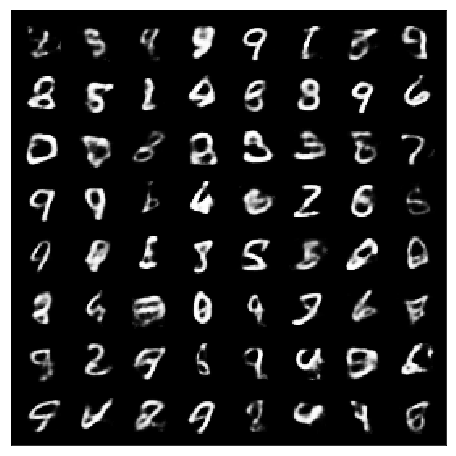

In [0]:
with torch.no_grad():
    decoder.eval()
    z = torch.randn(64, 20).to(device)
    x_recon = decoder(z).cpu()
show_mnist(x_recon)

# Anomalous Data

In [0]:
fashion_test = FashionMNIST(datasets_root, train=False, download=True, transform=transform)

emnist_transform = transforms.Compose([
    lambda each: transforms.functional.rotate(each, -90),
    transforms.functional.hflip,
    transforms.ToTensor()
])

try:
    letters_test = EMNIST(
        datasets_root,
        split='letters',
        train=False,
        download=True,
        transform=emnist_transform)
except HTTPError:
    class UpdatedEMNIST(torchvision.datasets.EMNIST):
        url = 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
        splits = ('byclass', 'bymerge', 'balanced', 'letters', 'digits', 'mnist')
    
    letters_test = UpdatedEMNIST(
        datasets_root,
        split='letters',
        train=False,
        download=True,
        transform=emnist_transform)
    
print(f'Fashion-MNIST Test: {len(fashion_test)}')
print(f'EMNIST/letters Test: {len(letters_test)}')

show_mnist(fashion_test)
show_mnist(letters_test)

fashion_loader = DataLoader(fashion_test, batch_size=test_batch_size, shuffle=True)
letters_loader = DataLoader(letters_test, batch_size=test_batch_size, shuffle=True)

In [0]:
def get_reconstruction_error(model, data_loader, device):
    errors= []

    with torch.no_grad():
        model.eval()
        for x, _ in data_loader:
            x = x.to(device)
            x_reco, _, _ = model(x)
            error_batch = reconstruction_error(x_reco, x, reduction='none').mean(dim=1)
            error_batch = error_batch.cpu().numpy()
            
            errors.append(error_batch)
    return np.concatenate(errors)

In [0]:
mnist_reco_error = get_reconstruction_error(model, test_loader, device)
fashion_reco_error = get_reconstruction_error(model, fashion_loader, device)
letters_reco_error = get_reconstruction_error(model, letters_loader, device)

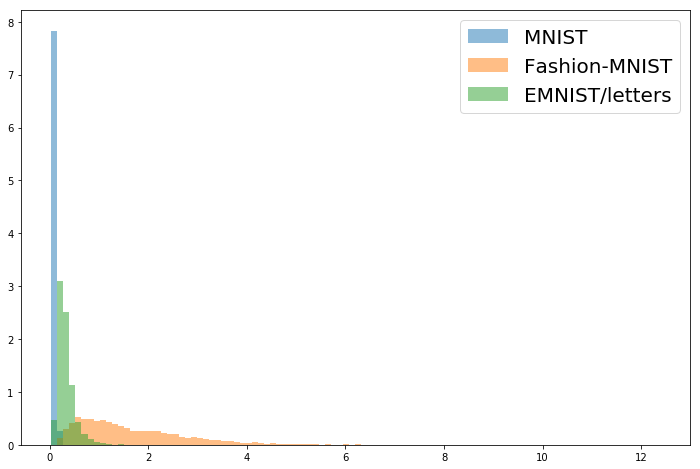

In [0]:
min_error = min([min(each) for  each in [mnist_reco_error, fashion_reco_error, letters_reco_error]])
max_error = max([max(each) for  each in [mnist_reco_error, fashion_reco_error, letters_reco_error]])

hist_kwargs  = {
    'alpha': 0.5,
    'range': (min_error, max_error),
    'bins': 100,
    'density': True
}

fig, ax = plt.subplots(figsize=(12, 8))
_ = ax.hist(mnist_reco_error, label='MNIST', **hist_kwargs)
_ = ax.hist(fashion_reco_error, label='Fashion-MNIST', **hist_kwargs)
_ = ax.hist(letters_reco_error, label='EMNIST/letters', **hist_kwargs)
ax.legend(fontsize=20)